Group: I-Need-More-Boolets



Members: <br>
Go, Ryan Jefferson <br>
Ejercito, Joshua Carl <br>
Moraña, Anton Louis <br>
Nieva, Samuel



Section: S11



# Introduction to the problem/task and dataset

This major course output tasked our group to select a real-word dataset from the selection given. This group has selected the stars dataset, which is a dataset containing spectral characteristics derived from pictures taken by the SDSS (Sloan Digital Sky Survey). This dataset's main use is spectral classification, i.e., classifying whether a celestial body is a star, a quasar or an entire galaxy.

Using the dataset, the group is to perform the following:

- Describe the dataset
- Perform Data Pre-processing and Cleaning
- Perform Exploratory Data Analysis
- Select 3 Machine Learning Models
- Perform model training
- Perform hyperparameter tuning
- Extract insights from the data



# Description of the dataset

As stated earlier, the Stars datasets contains spectral characteristics from celestial bodies that can be used to classify it as either a quasar, star, or galaxy. This dataset is made up of 100,000 obersavations of space taken by the SDSS (Sloan Digital Sky Survey) with each observations having 18 features. The SDSS takes these observations through the use of a 2.5m wide located at Apache Point Observatory in New Mexico. The telescope is described in detail in a paper by Gunn et al. (2006), and it is through this powerful telescope that a robust astronomical survey is created, from which datasets such as this are derived.

The following are the description of their features:

1. obj_ID =  the unique value that identifies the object in the image catalog used by th CAS (Chinese Academy of Sciences).
2. alpha = it contains the right ascension angle, it is measured from the start of a point which is called vernal equinox and go eastward. It is expressed in hours, minutes, and seconds. Vernal equinox is when the sun is exactly above the equator and day and night are of equal day. It is similar to the longitude in space.
3. delta = it contains the declination angle, which shows the angle between the celestial equator and a point on the celestial sphere. It is like the latitude in space which results can either be positive or negative. Positive means that the object is located north while negative means it is located south.
4. u – Ultraviolet filter in the photometric system.
5. g – Green filter in the photometric system.
6. r – Red filter in the photometric system.
7. i – Near Infrared filter in the photometric system.
8. z – Infrared filter in the photometric system.
9. run_ID – Run Number used to identify the specific scan.
10. rereun_ID – Rerun Number to specify how the image was processed.
11. cam_col – Camera column to identify the scanline within the run.
12. field_ID – Field number to identify each field.
13. spec_obj_ID – Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class).
14. class – object class (galaxy, star or quasar object). This is the label the group will be tasking the models to predict.
15. redshift – redshift value based on the increase in wavelength.
16. plate – plate ID, identifies each plate in SDSS (Sloan Digital Sky Survey).
17. MJD – Modified Julian Date, used to indicate when a given piece of SDSS (Sloan Digital Sky Survey) data was taken.
18. fiber_ID – identifies the fiber that pointed the light at the focal plane in each observation.

The first few rows of the dataset look like this:



In [3]:
import pandas as pd
import numpy as np

seed_num = 12

np.random.seed(seed_num)

stars = pd.read_csv('stars.csv')
print("stars dataset shape: ", stars.shape)
stars.head()

stars dataset shape:  (100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


The following shows the number of data points for each class.

In [4]:
stars['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

The following shows the datatypes of each feature within the dataset:

In [5]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

# List of requirements

The group will be using Python's scikit learn library for their classification models (I think), scipy, scikit, numpy and pandas array for processing data, and matplotlib for visualizing data (add stuff if need pa)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV

# Data Cleaning and Preprocessing



To begin, we assign a set of columns that will be the focus for data cleaning and preprocessing, namely the `u`, `g`, `r`, `i`, `z`, and `redshift` columns.

In [7]:
columns_to_clean = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

## Replacement of `obj_ID` column



The `obj_ID` column assigns a unique ID for each observation in the dataset, although it is represented in a floating point format. For the purposes of the study, this will be replaced with a similarly-named column that utilizes integer IDs instead in order to simplify the access to each element.

In [8]:
stars = stars.drop(['obj_ID'], axis=1)
stars['obj_ID'] = np.arange(len(stars))
stars.insert(0, 'obj_ID', stars.pop('obj_ID'))
stars

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


## Checking for empty observations

Checking was done for any entries with missing/null features by instantiating another stars dataset whose entries are filtered off of null features.

In [9]:
nan_variables = stars[stars.isnull().any(axis=1)].index
stars_nonull = stars.drop(labels=nan_variables).reset_index(drop=True)
print("stars dataset shape (no null): ", stars_nonull.shape)

stars dataset shape (no null):  (100000, 18)


As shown by the resulting filtered dataset and comparing its shape to the original dataset, it was shown that all entries have all their features accounted for.

## Checking for duplicate entries

Any duplicated entries was checked first by comparing all entries' columns to each other

In [10]:
stars.duplicated().any()

False

As shown, there are no duplicated entries within the dataset.

## Checking for outliers

The removal of outliers aims to craft a dataset whose subset can be used for training data that is generally representative of each classes. We will first check for the existence of outliers in this instance, and any suspicious outliers that implies default/placeholder values will be removed from analysis.


In [11]:
stars[(np.abs(stats.zscore(stars[columns_to_clean])) < 3).all(axis=1)].shape

(97884, 18)

There are 2116 data points that are considered as outliers based from the z-score metric (>= 3 standard deviations from the mean). In order to know more about these outliers, the features are drawn in a boxplot, displaying their minimum and maximum values respectively.

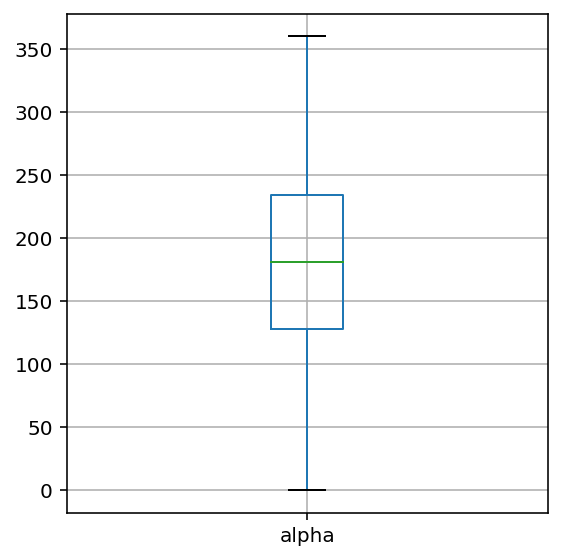

" alpha " minimum value:  0.0055278279239701
" alpha " maximum value:  359.999809770956


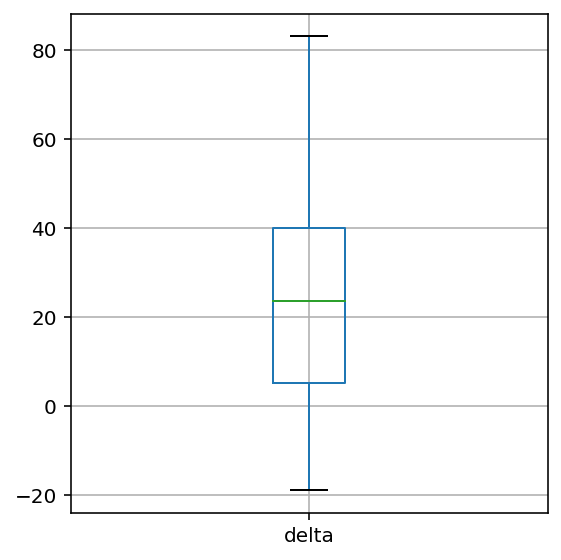

" delta " minimum value:  -18.7853280771825
" delta " maximum value:  83.00051858898


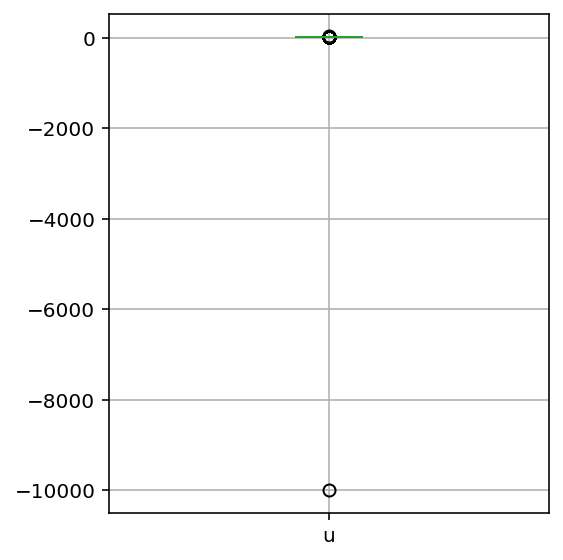

" u " minimum value:  -9999.0
" u " maximum value:  32.78139


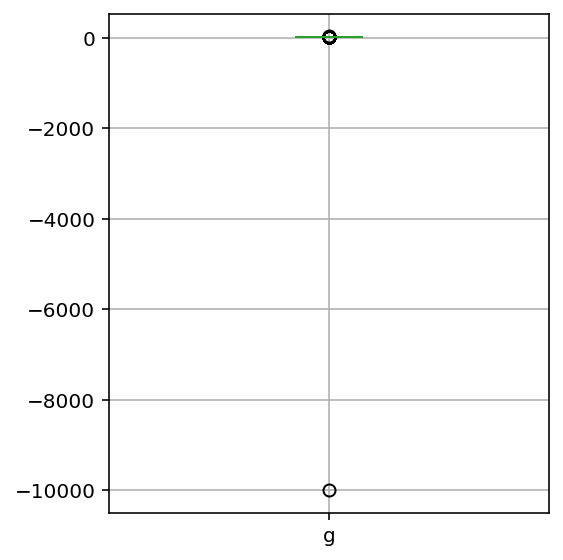

" g " minimum value:  -9999.0
" g " maximum value:  31.60224


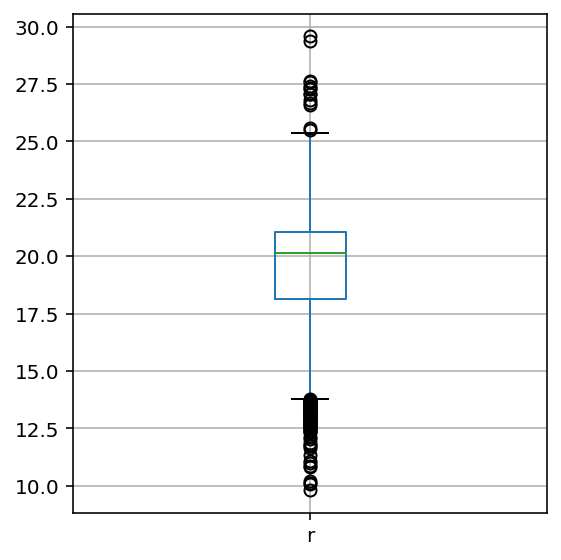

" r " minimum value:  9.82207
" r " maximum value:  29.57186


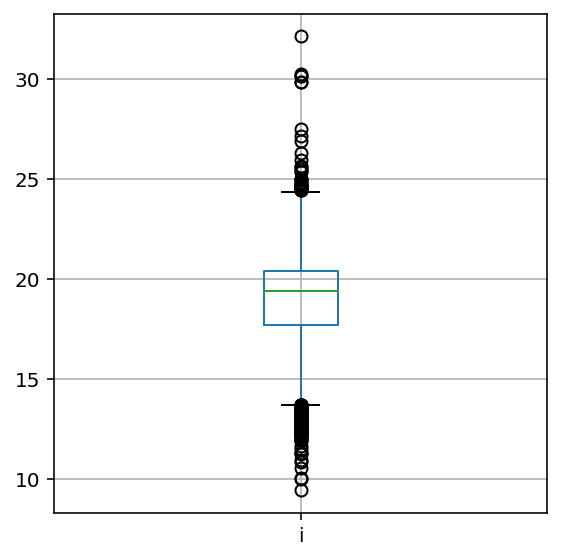

" i " minimum value:  9.469903
" i " maximum value:  32.14147


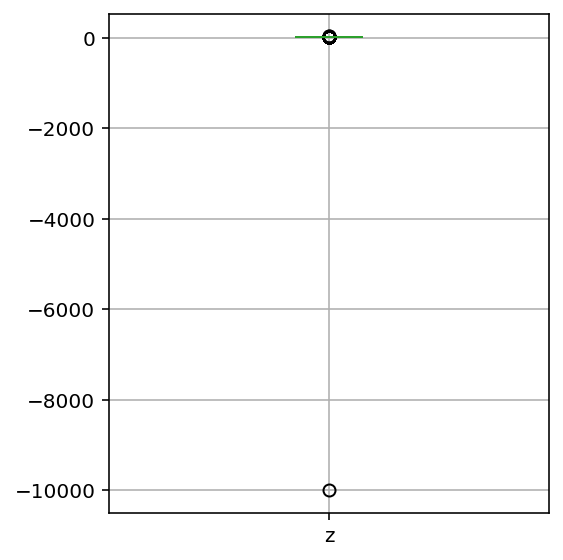

" z " minimum value:  -9999.0
" z " maximum value:  29.38374


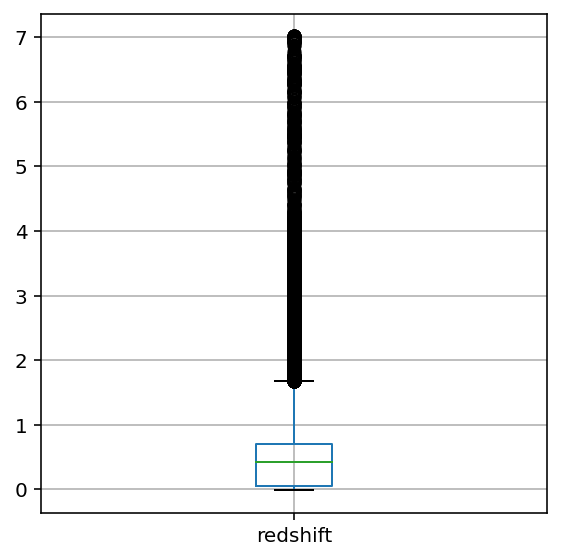

" redshift " minimum value:  -0.009970667
" redshift " maximum value:  7.011245


In [12]:
for col in columns_to_clean:
    stars.boxplot(col, figsize=(4, 4))
    plt.tight_layout()
    plt.show()
    print("\"",col,"\" minimum value: ", stars[col].min())
    print("\"",col,"\" maximum value: ", stars[col].max())

Some features have values equated to a whole value of \-9999. This may indicate that these features were not recorded/not available for that observation, thus putting a default value for those features. To resolve this, we will remove the associated entries that has default values for these certain features.


In [13]:
default_value = stars['u'].min()
stars = stars[stars['u'] != default_value]
stars = stars[stars['g'] != default_value]
stars = stars[stars['z'] != default_value]
stars.shape

(99999, 18)

Based from the filtered dataset, there is only one entry that contains such default values. Any other outliers will be resolved by applying the robust scaling method for normalization.



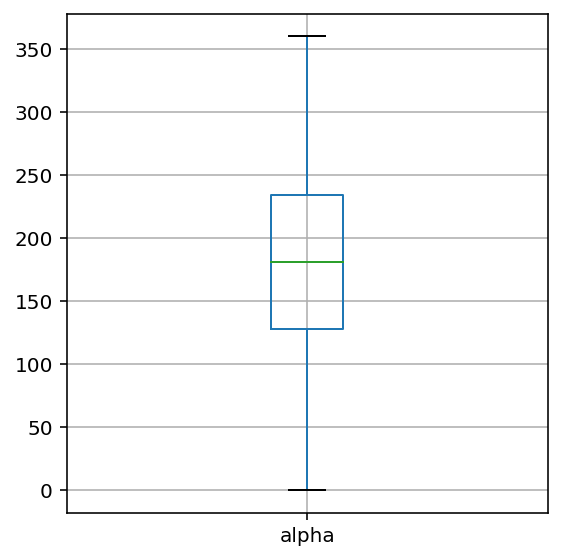

" alpha " minimum value:  0.0055278279239701
" alpha " maximum value:  359.999809770956


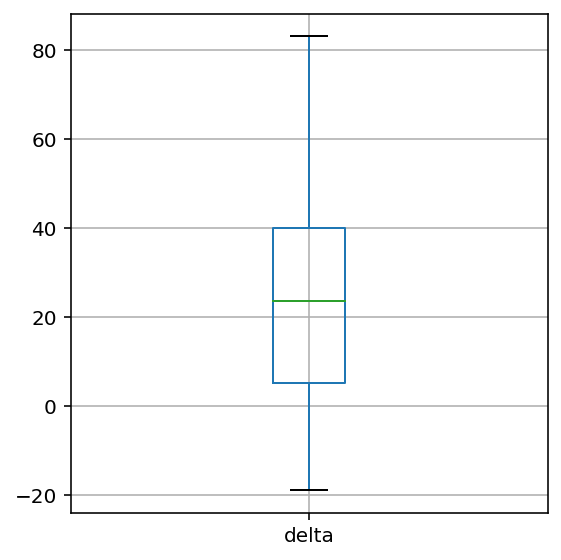

" delta " minimum value:  -18.7853280771825
" delta " maximum value:  83.00051858898


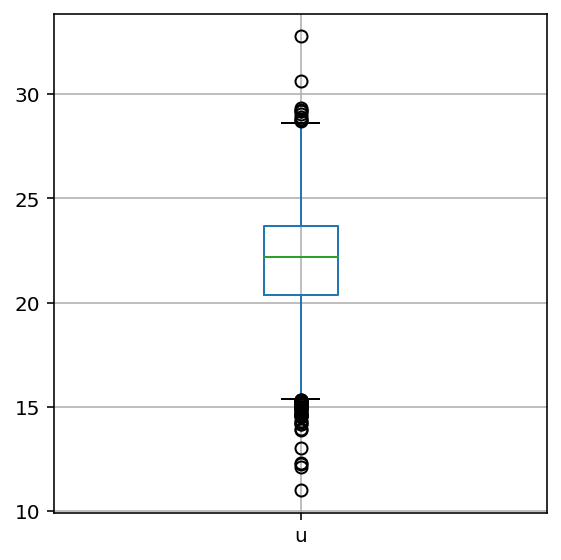

" u " minimum value:  10.99623
" u " maximum value:  32.78139


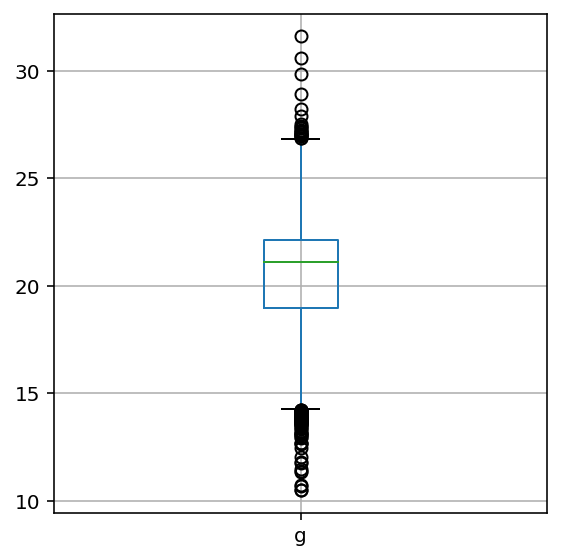

" g " minimum value:  10.4982
" g " maximum value:  31.60224


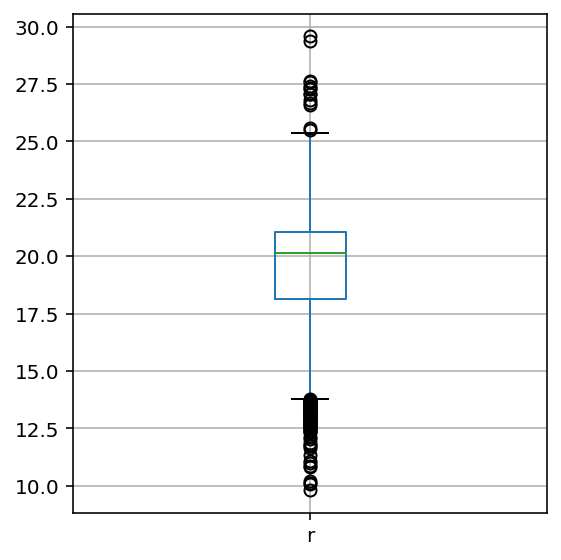

" r " minimum value:  9.82207
" r " maximum value:  29.57186


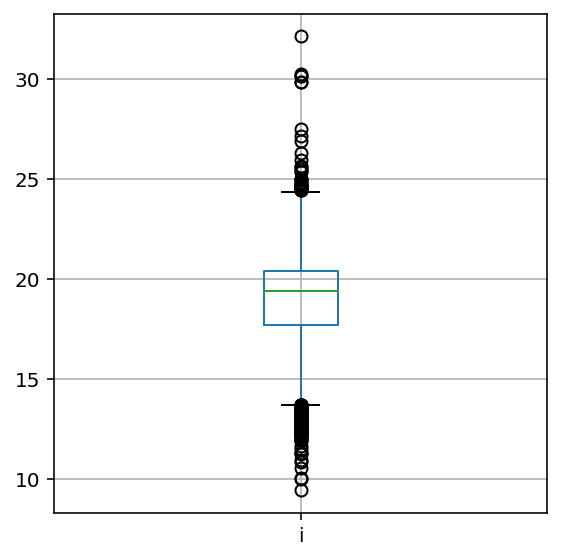

" i " minimum value:  9.469903
" i " maximum value:  32.14147


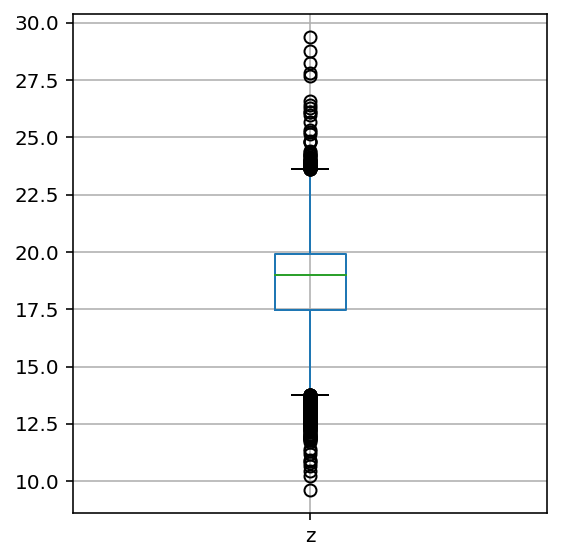

" z " minimum value:  9.612333
" z " maximum value:  29.38374


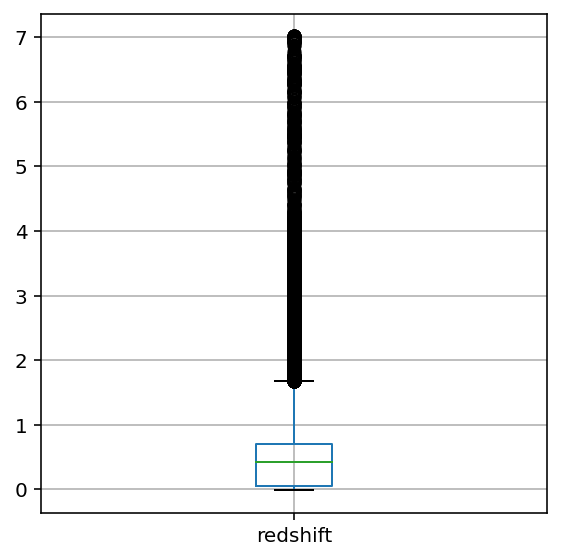

" redshift " minimum value:  -0.009970667
" redshift " maximum value:  7.011245


In [14]:
for col in columns_to_clean:
    stars.boxplot(col, figsize=(4, 4))
    plt.tight_layout()
    plt.show()
    print("\"",col,"\" minimum value: ", stars[col].min())
    print("\"",col,"\" maximum value: ", stars[col].max())

The boxplots indicates that any extreme outliers that comes from the default values were successfully removed. However, the `redshift` feature may require additional feature engineering in the form of logarithmic transformation, which will be done in the normalization phase.



## Logarithmic transformation of the `redshift` feature



The `redshift` feature will be transformed by implementing a helper function to be used in the normalization process.

In [15]:
def log_transform_feature(df, feature):
    feature_min = df[feature].min()
    feature_max = df[feature].max()
    # shifter to convert negaative values to positive, and to keep any values above zero for log computation
    shifter = abs(feature_min) + 0.001
        
    df[feature] = np.log(df[feature] + shifter)
    
    return df

## Fixing `obj_ID` after the removal of outliers

Since the outliers were removed, the row obj_ID may not reflect it's actual position in the dataset. To fix this, we simply reassign the obj_IDs incrementally.



In [16]:
stars = stars.drop(['obj_ID'], axis=1)
stars['obj_ID'] = np.arange(len(stars))
stars.insert(0, 'obj_ID', stars.pop('obj_ID'))
stars

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99994,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,99995,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,99996,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,99997,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


## Normalization



Normalization is performed for the previously\-specified columns in order to equally weight\-in each of the features for the model training and evaluation. The robust scaler will be applied as normalization technique to account for the massive outliers for some features such as `u`, `g,` and `z`.

In order to begin the normalization process, the original dataset is split into training and test dataset alongside splitting their features and labels, and are then normalized. This was done to simulate the prediction on unseen data by only doing the normalization computations within the split datasets themselves to avoid imposing any bias for the evaluation. Additionally, the redshift feature is log\-transformed first in order to extract more range from its skewed distribution.


In [17]:
# For use in EDA
og_stars = stars

cols = ['u','g','r','i','z','redshift']
X = stars[cols]
y = stars["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=seed_num, test_size=0.3, stratify=y)

# log-transform redshift features first
X_train = log_transform_feature(X_train, "redshift")
scaler = RobustScaler().fit(X_train[cols])
X_train[cols] = scaler.transform(X_train[cols])
X_train = X_train.to_numpy()

X_test = log_transform_feature(X_test, "redshift")
scaler = RobustScaler().fit(X_test[cols])
X_test[cols] = scaler.transform(X_test[cols])
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

The original stars dataset is also normalized for comparison in the EDA process.

In [18]:
stars = log_transform_feature(stars, "redshift")
scaler = RobustScaler().fit(stars[columns_to_clean])
stars[columns_to_clean] = scaler.transform(stars[columns_to_clean])
stars.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,-0.425010,0.254593,0.509638,0.372125,0.092712,-0.089865,-0.085718,3606,301,2,79,6.543777e+18,GALAXY,0.165130,5812,56354,171
1,1,-0.339118,0.219477,0.779129,0.548340,0.845354,0.661718,1.060716,4518,301,5,119,1.176014e+19,GALAXY,0.249518,10445,58158,427
2,2,-0.363910,0.343441,0.924697,0.495154,0.166535,-0.021237,-0.022896,3606,301,2,120,5.152200e+18,GALAXY,0.171176,4576,55592,299
3,3,1.483780,-0.691984,-0.012689,0.847428,0.510936,0.412648,0.099785,4192,301,3,214,1.030107e+19,GALAXY,0.323658,9149,58039,775
4,4,1.545274,-0.070858,-0.822160,-1.114330,-1.247111,-1.286691,-1.406334,8102,301,3,137,6.891865e+18,GALAXY,-0.514844,6121,56187,842


In [19]:
columns_to_use = ['obj_ID','alpha','delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']
columns_data = ['alpha','delta','u','g','r','i','z','redshift']

labels = {'GALAXY':0,'STAR':1,'QSO':2}

stars_df = stars[columns_to_use]
stars_df['class'] = stars_df['class'].map(labels)

stars_df.set_index('obj_ID')

/tmp/ipykernel_1032/3563447924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_df['class'] = stars_df['class'].map(labels)


,alpha,delta,u,g,r,i,z,redshift,class
obj_ID,,,,,,,,,
0,-0.425010,0.254593,0.509638,0.372125,0.092712,-0.089865,-0.085718,0.165130,0
1,-0.339118,0.219477,0.779129,0.548340,0.845354,0.661718,1.060716,0.249518,0
2,-0.363910,0.343441,0.924697,0.495154,0.166535,-0.021237,-0.022896,0.171176,0
3,1.483780,-0.691984,-0.012689,0.847428,0.510936,0.412648,0.099785,0.323658,0
4,1.545274,-0.070858,-0.822160,-1.114330,-1.247111,-1.286691,-1.406334,-0.514844,0
...,...,...,...,...,...,...,...,...,...
99994,-1.328101,-0.755034,-0.003463,0.593924,0.611459,0.713276,0.703612,-1.539587,0
99995,-1.423299,-0.110709,0.153532,0.407262,0.111626,0.132286,0.166915,-0.018958,0
99996,0.410679,-0.228628,-0.302836,-0.579370,-0.660376,-0.643642,-0.671624,-0.433603,0


array([[<Axes: title={'center': 'alpha'}, xlabel='class'>,
        <Axes: title={'center': 'delta'}, xlabel='class'>,
        <Axes: title={'center': 'u'}, xlabel='class'>],
       [<Axes: title={'center': 'g'}, xlabel='class'>,
        <Axes: title={'center': 'r'}, xlabel='class'>,
        <Axes: title={'center': 'i'}, xlabel='class'>],
       [<Axes: title={'center': 'z'}, xlabel='class'>,
        <Axes: title={'center': 'redshift'}, xlabel='class'>, <Axes: >]],
      dtype=object)

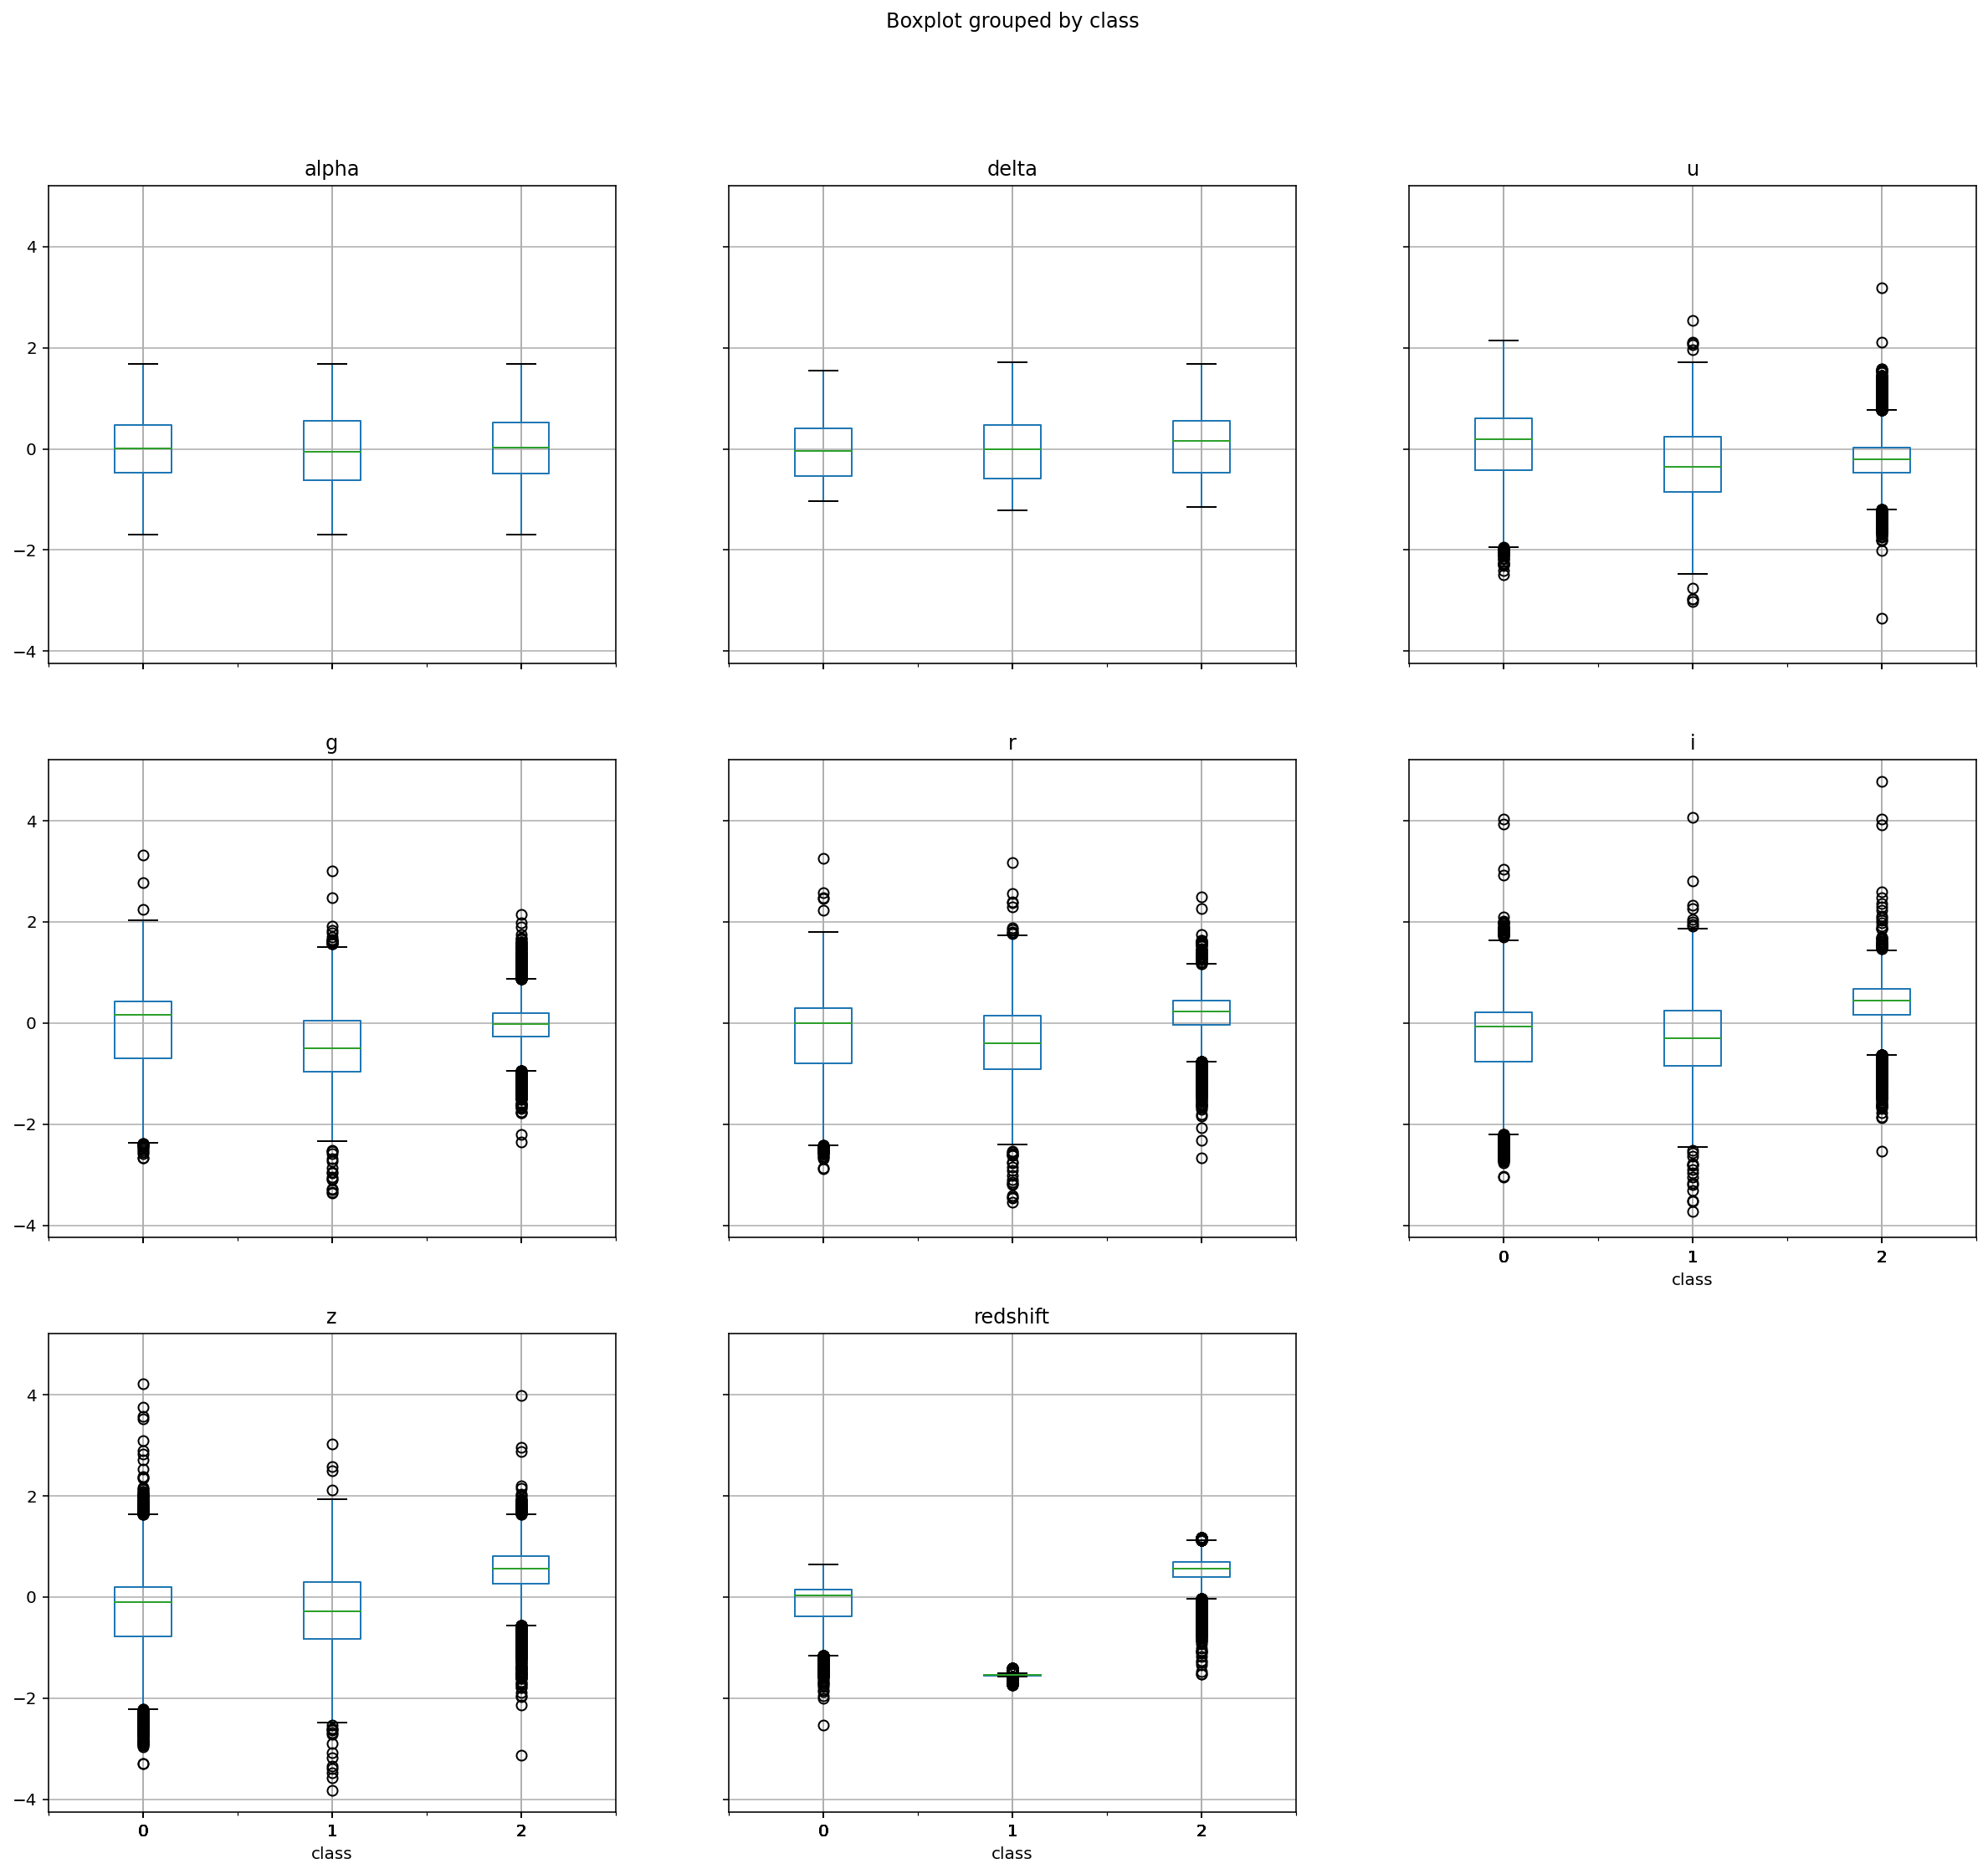

In [20]:
stars_df.boxplot(columns_data, by="class", figsize=(20,18))

# Exploratory Data Analysis



## Central Tendencies

To gain a better understanding of the data, we can begin with examining the central tendencies of the data. These would be the mean, median and mode.



### Means

For the means, we can take the means of each feature, pertaining to each class and compare them to one another. Putting the means together in a table, it would look like this:



In [21]:
means_df = og_stars.groupby('class').mean()
means_df = means_df[['alpha','delta','u','g','r','i','z','redshift']].T

normalized_means_df = stars.groupby('class').mean()
normalized_means_df = normalized_means_df[['alpha','delta','u','g','r','i','z','redshift']].T

print(means_df)

print("\n")

print(normalized_means_df)

class       GALAXY       QSO      STAR
alpha    -0.027692 -0.004007 -0.062686
delta    -0.003814  0.090987 -0.004224
u         0.122408 -0.189358 -0.307433
g        -0.061367 -0.055006 -0.469454
r        -0.184860  0.171461 -0.405056
i        -0.207625  0.385110 -0.323317
z        -0.225763  0.513001 -0.272450
redshift -0.123088  0.513845 -1.544378


class       GALAXY       QSO      STAR
alpha    -0.027692 -0.004007 -0.062686
delta    -0.003814  0.090987 -0.004224
u         0.122408 -0.189358 -0.307433
g        -0.061367 -0.055006 -0.469454
r        -0.184860  0.171461 -0.405056
i        -0.207625  0.385110 -0.323317
z        -0.225763  0.513001 -0.272450
redshift -0.123088  0.513845 -1.544378


We can then graph it to a bar plot to make it easier to compare to one another. It would look like this:



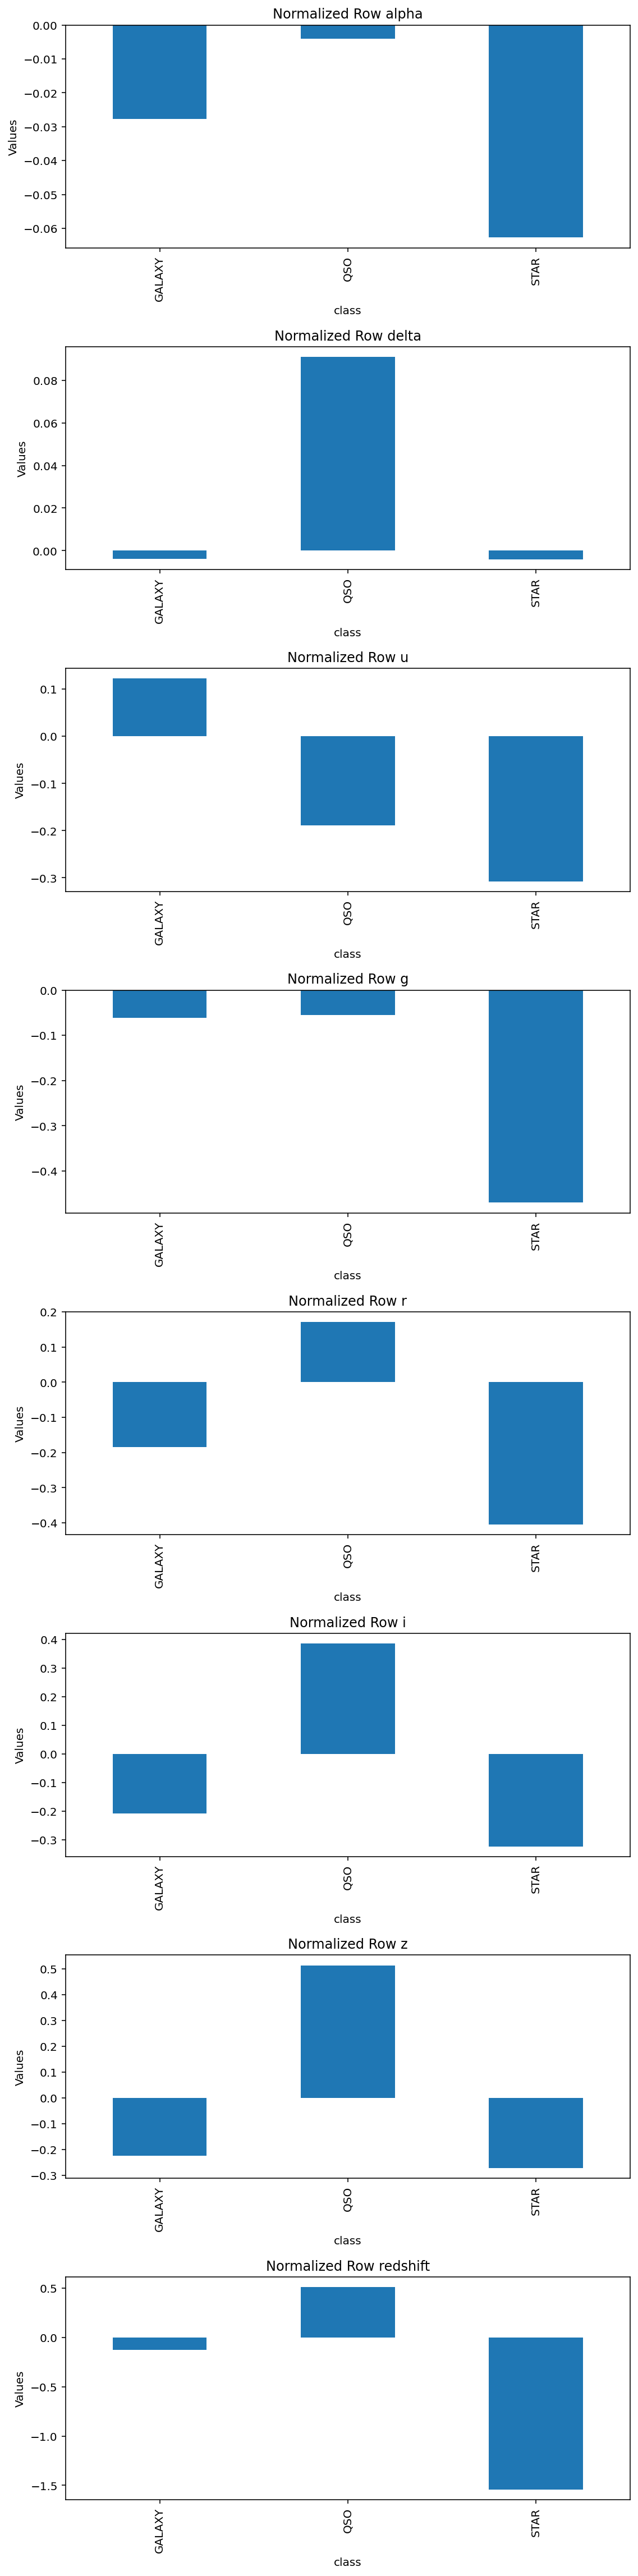

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(means_df), figsize=(8, 4 * len(means_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(means_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Normalized Row {index}')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

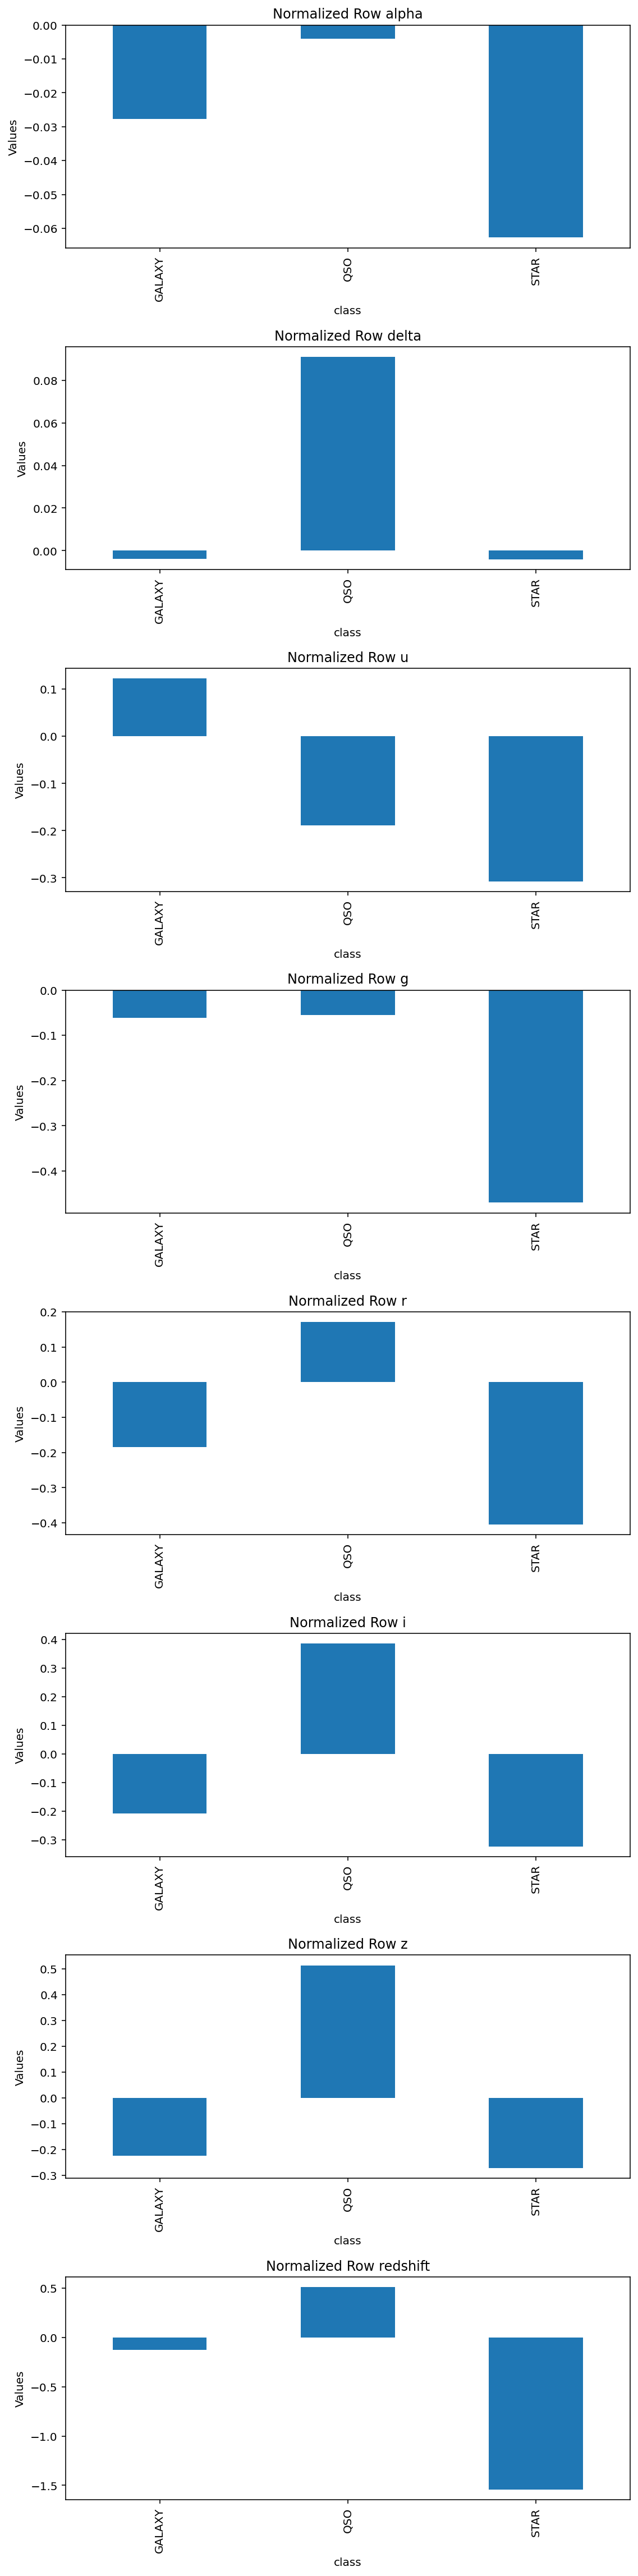

In [23]:
fig, axes = plt.subplots(nrows=len(normalized_means_df), figsize=(8, 4 * len(normalized_means_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(normalized_means_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Normalized Row {index}')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Analysis goes here, will add later



In [24]:
mode_df = og_stars.groupby('class').apply(lambda x: x.mode().iloc[0])
mode_df = mode_df[['alpha', 'delta', 'u','g','r','i','z','redshift']].T

normalized_mode_df = stars.groupby('class').apply(lambda x: x.mode().iloc[0])
normalized_mode_df = normalized_mode_df[['alpha','delta','u','g','r','i','z','redshift']].T

print(mode_df)
print("\n")
print(normalized_mode_df)

class       GALAXY       QSO      STAR
0                                     
alpha    -1.373892 -1.700453 -1.700275
delta    -0.697713 -1.140221 -1.220914
u         0.736272  0.736272  0.736269
g         0.417117 -0.337410  1.270982
r         0.205274 -0.174555  1.607676
i        -0.767828  0.219658  1.860444
z         1.553597  1.553597  1.553597
redshift -1.539587  1.163395 -1.405286


class       GALAXY       QSO      STAR
0                                     
alpha    -1.373892 -1.700453 -1.700275
delta    -0.697713 -1.140221 -1.220914
u         0.736272  0.736272  0.736269
g         0.417117 -0.337410  1.270982
r         0.205274 -0.174555  1.607676
i        -0.767828  0.219658  1.860444
z         1.553597  1.553597  1.553597
redshift -1.539587  1.163395 -1.405286


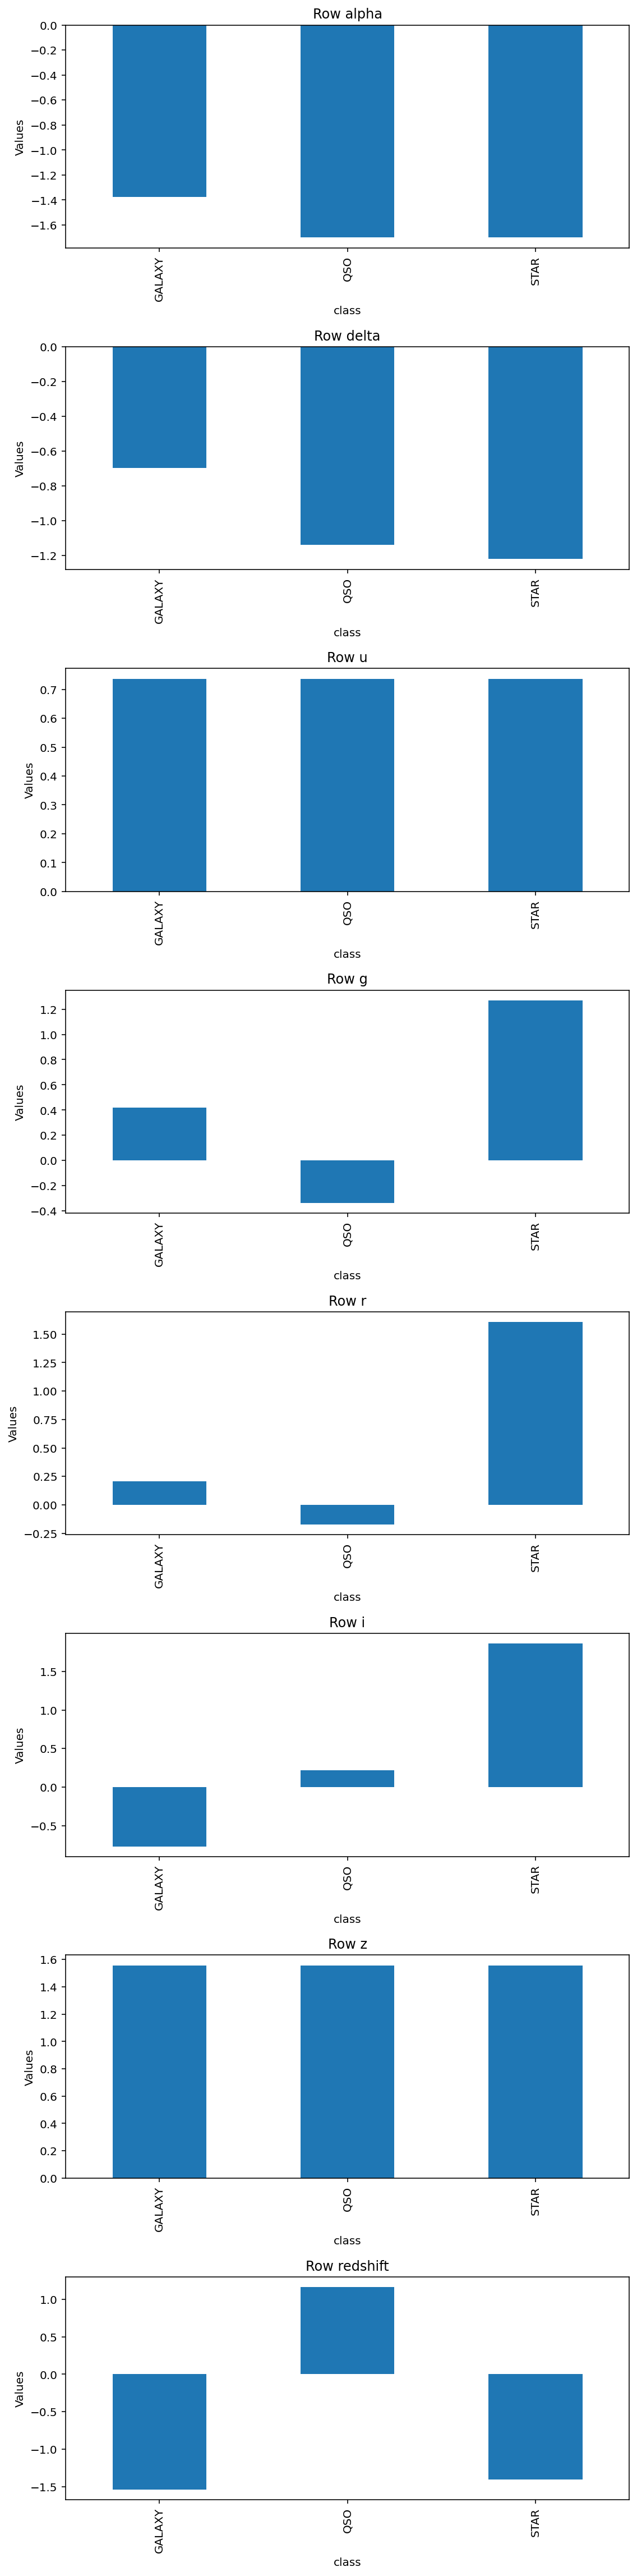

In [25]:
fig, axes = plt.subplots(nrows=len(mode_df), figsize=(8, 4 * len(mode_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(mode_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Row {index}')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

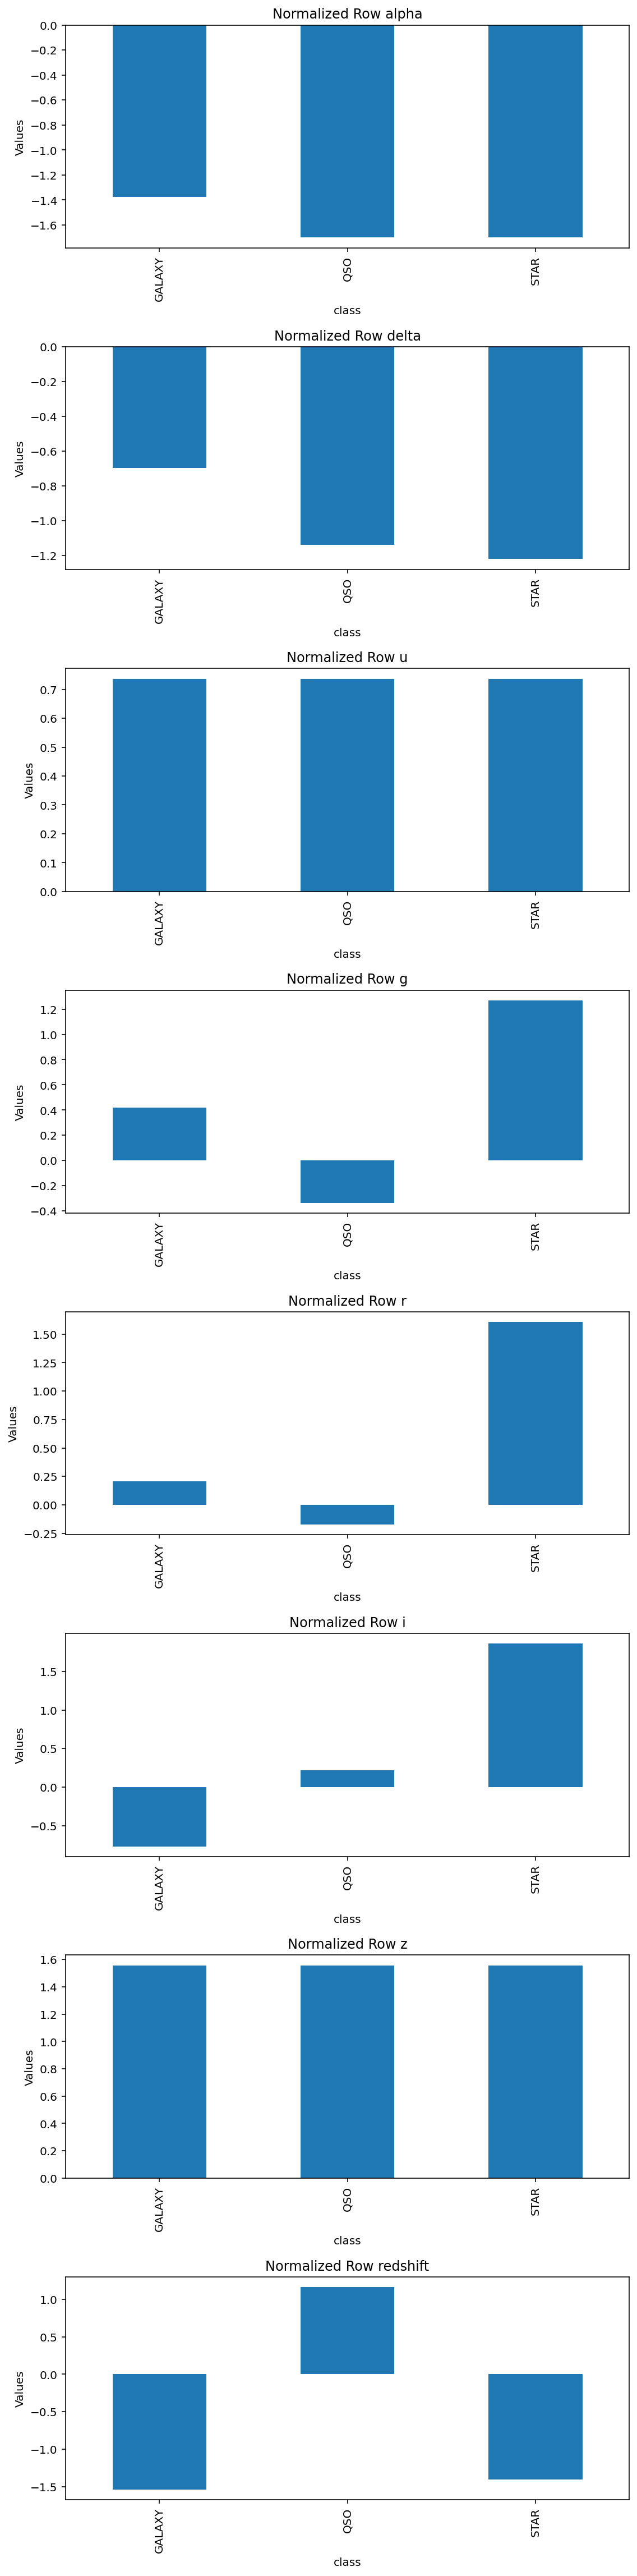

In [26]:
fig, axes = plt.subplots(nrows=len(normalized_mode_df), figsize=(8, 4 * len(normalized_mode_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(normalized_mode_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Normalized Row {index}')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [27]:
median_df = og_stars.groupby('class').median()
median_df = median_df[['alpha','delta','u','g','r','i','z','redshift']].T

normalized_median_df = stars.groupby('class').median()
normalized_median_df = normalized_median_df[['alpha','delta','u','g','r','i','z','redshift']].T


print(median_df)
print("\n")
print(normalized_median_df)

class       GALAXY       QSO      STAR
alpha     0.003904  0.026152 -0.063463
delta    -0.038693  0.162649 -0.007075
u         0.198685 -0.202664 -0.350364
g         0.152688 -0.013817 -0.492982
r        -0.007123  0.222555 -0.402263
i        -0.068121  0.441764 -0.305064
z        -0.096724  0.556589 -0.278573
redshift  0.029772  0.551986 -1.542501


class       GALAXY       QSO      STAR
alpha     0.003904  0.026152 -0.063463
delta    -0.038693  0.162649 -0.007075
u         0.198685 -0.202664 -0.350364
g         0.152688 -0.013817 -0.492982
r        -0.007123  0.222555 -0.402263
i        -0.068121  0.441764 -0.305064
z        -0.096724  0.556589 -0.278573
redshift  0.029772  0.551986 -1.542501


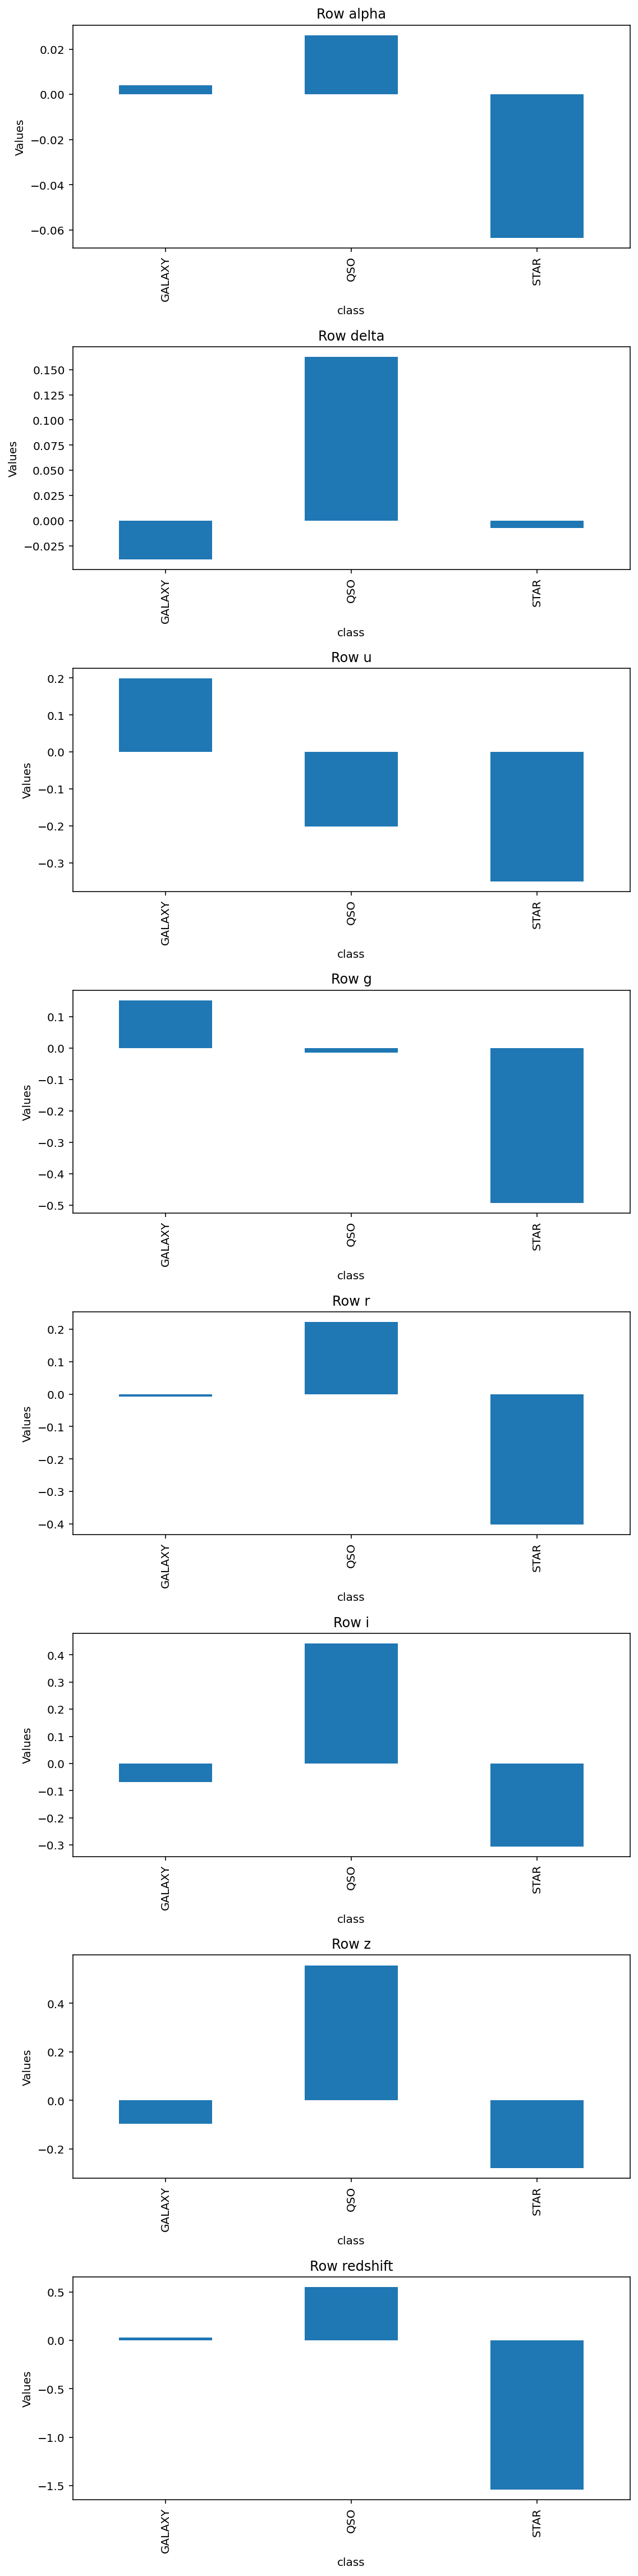

In [28]:
fig, axes = plt.subplots(nrows=len(median_df), figsize=(8, 4 * len(median_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(median_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Row {index}')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

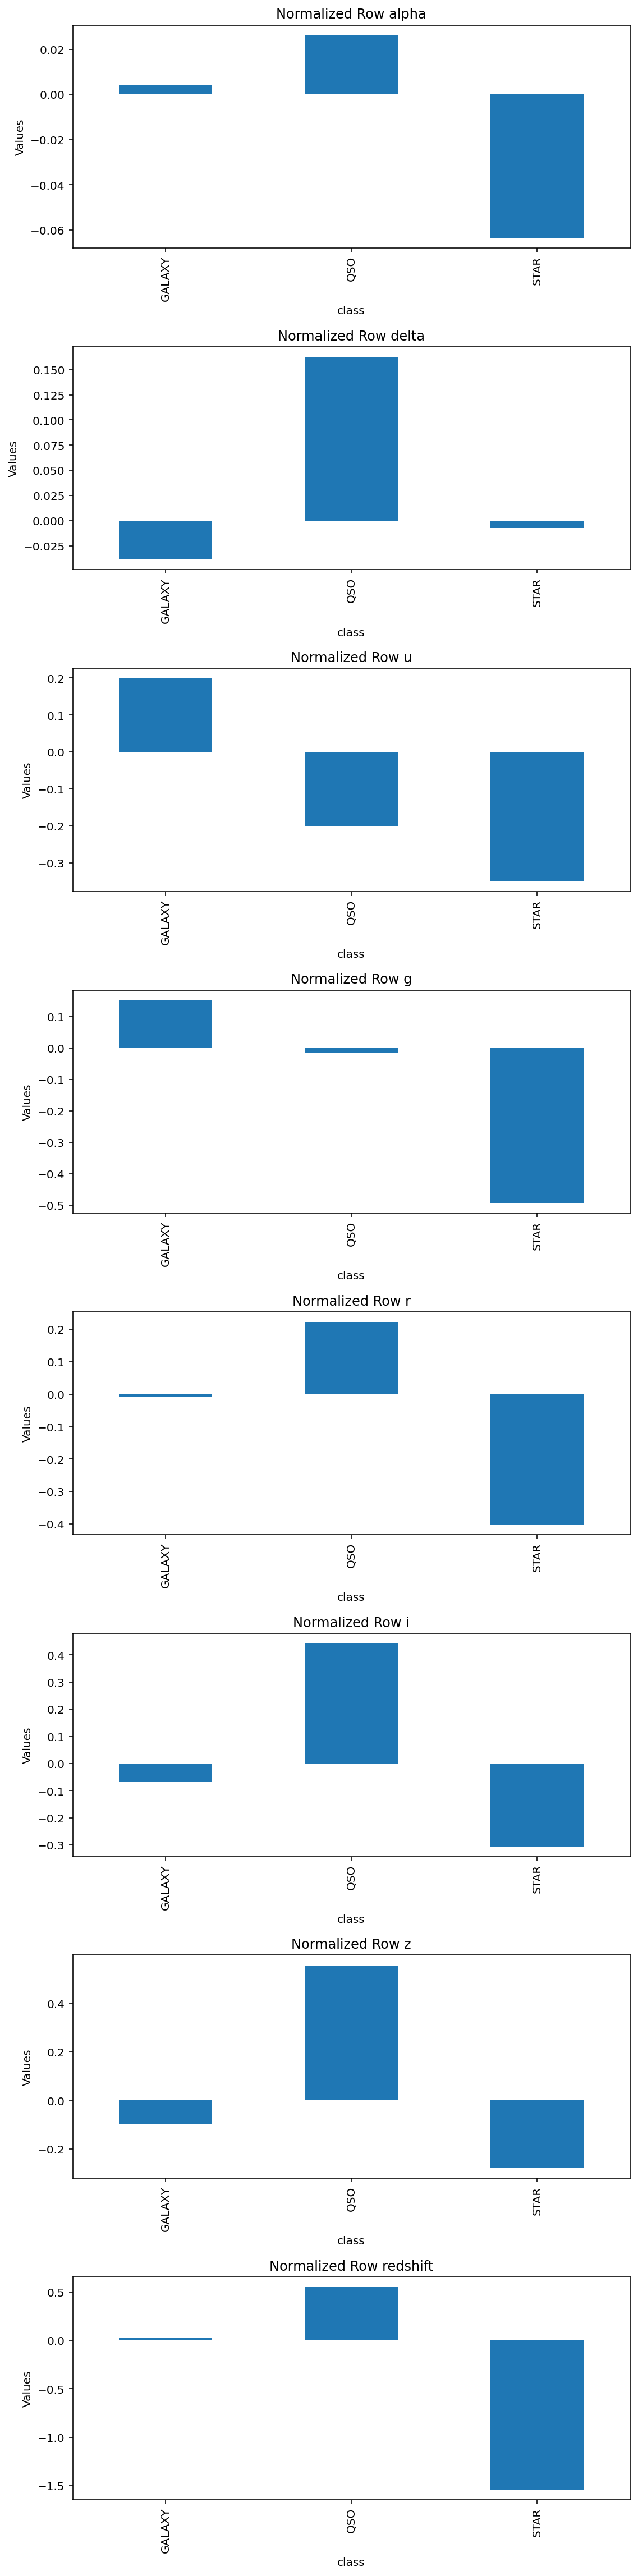

In [29]:
fig, axes = plt.subplots(nrows=len(normalized_median_df), figsize=(8, 4 * len(normalized_median_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(normalized_median_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Normalized Row {index}')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'alpha'}, xlabel='class'>,
        <Axes: title={'center': 'delta'}, xlabel='class'>,
        <Axes: title={'center': 'u'}, xlabel='class'>],
       [<Axes: title={'center': 'g'}, xlabel='class'>,
        <Axes: title={'center': 'r'}, xlabel='class'>,
        <Axes: title={'center': 'i'}, xlabel='class'>],
       [<Axes: title={'center': 'z'}, xlabel='class'>,
        <Axes: title={'center': 'redshift'}, xlabel='class'>, <Axes: >]],
      dtype=object)

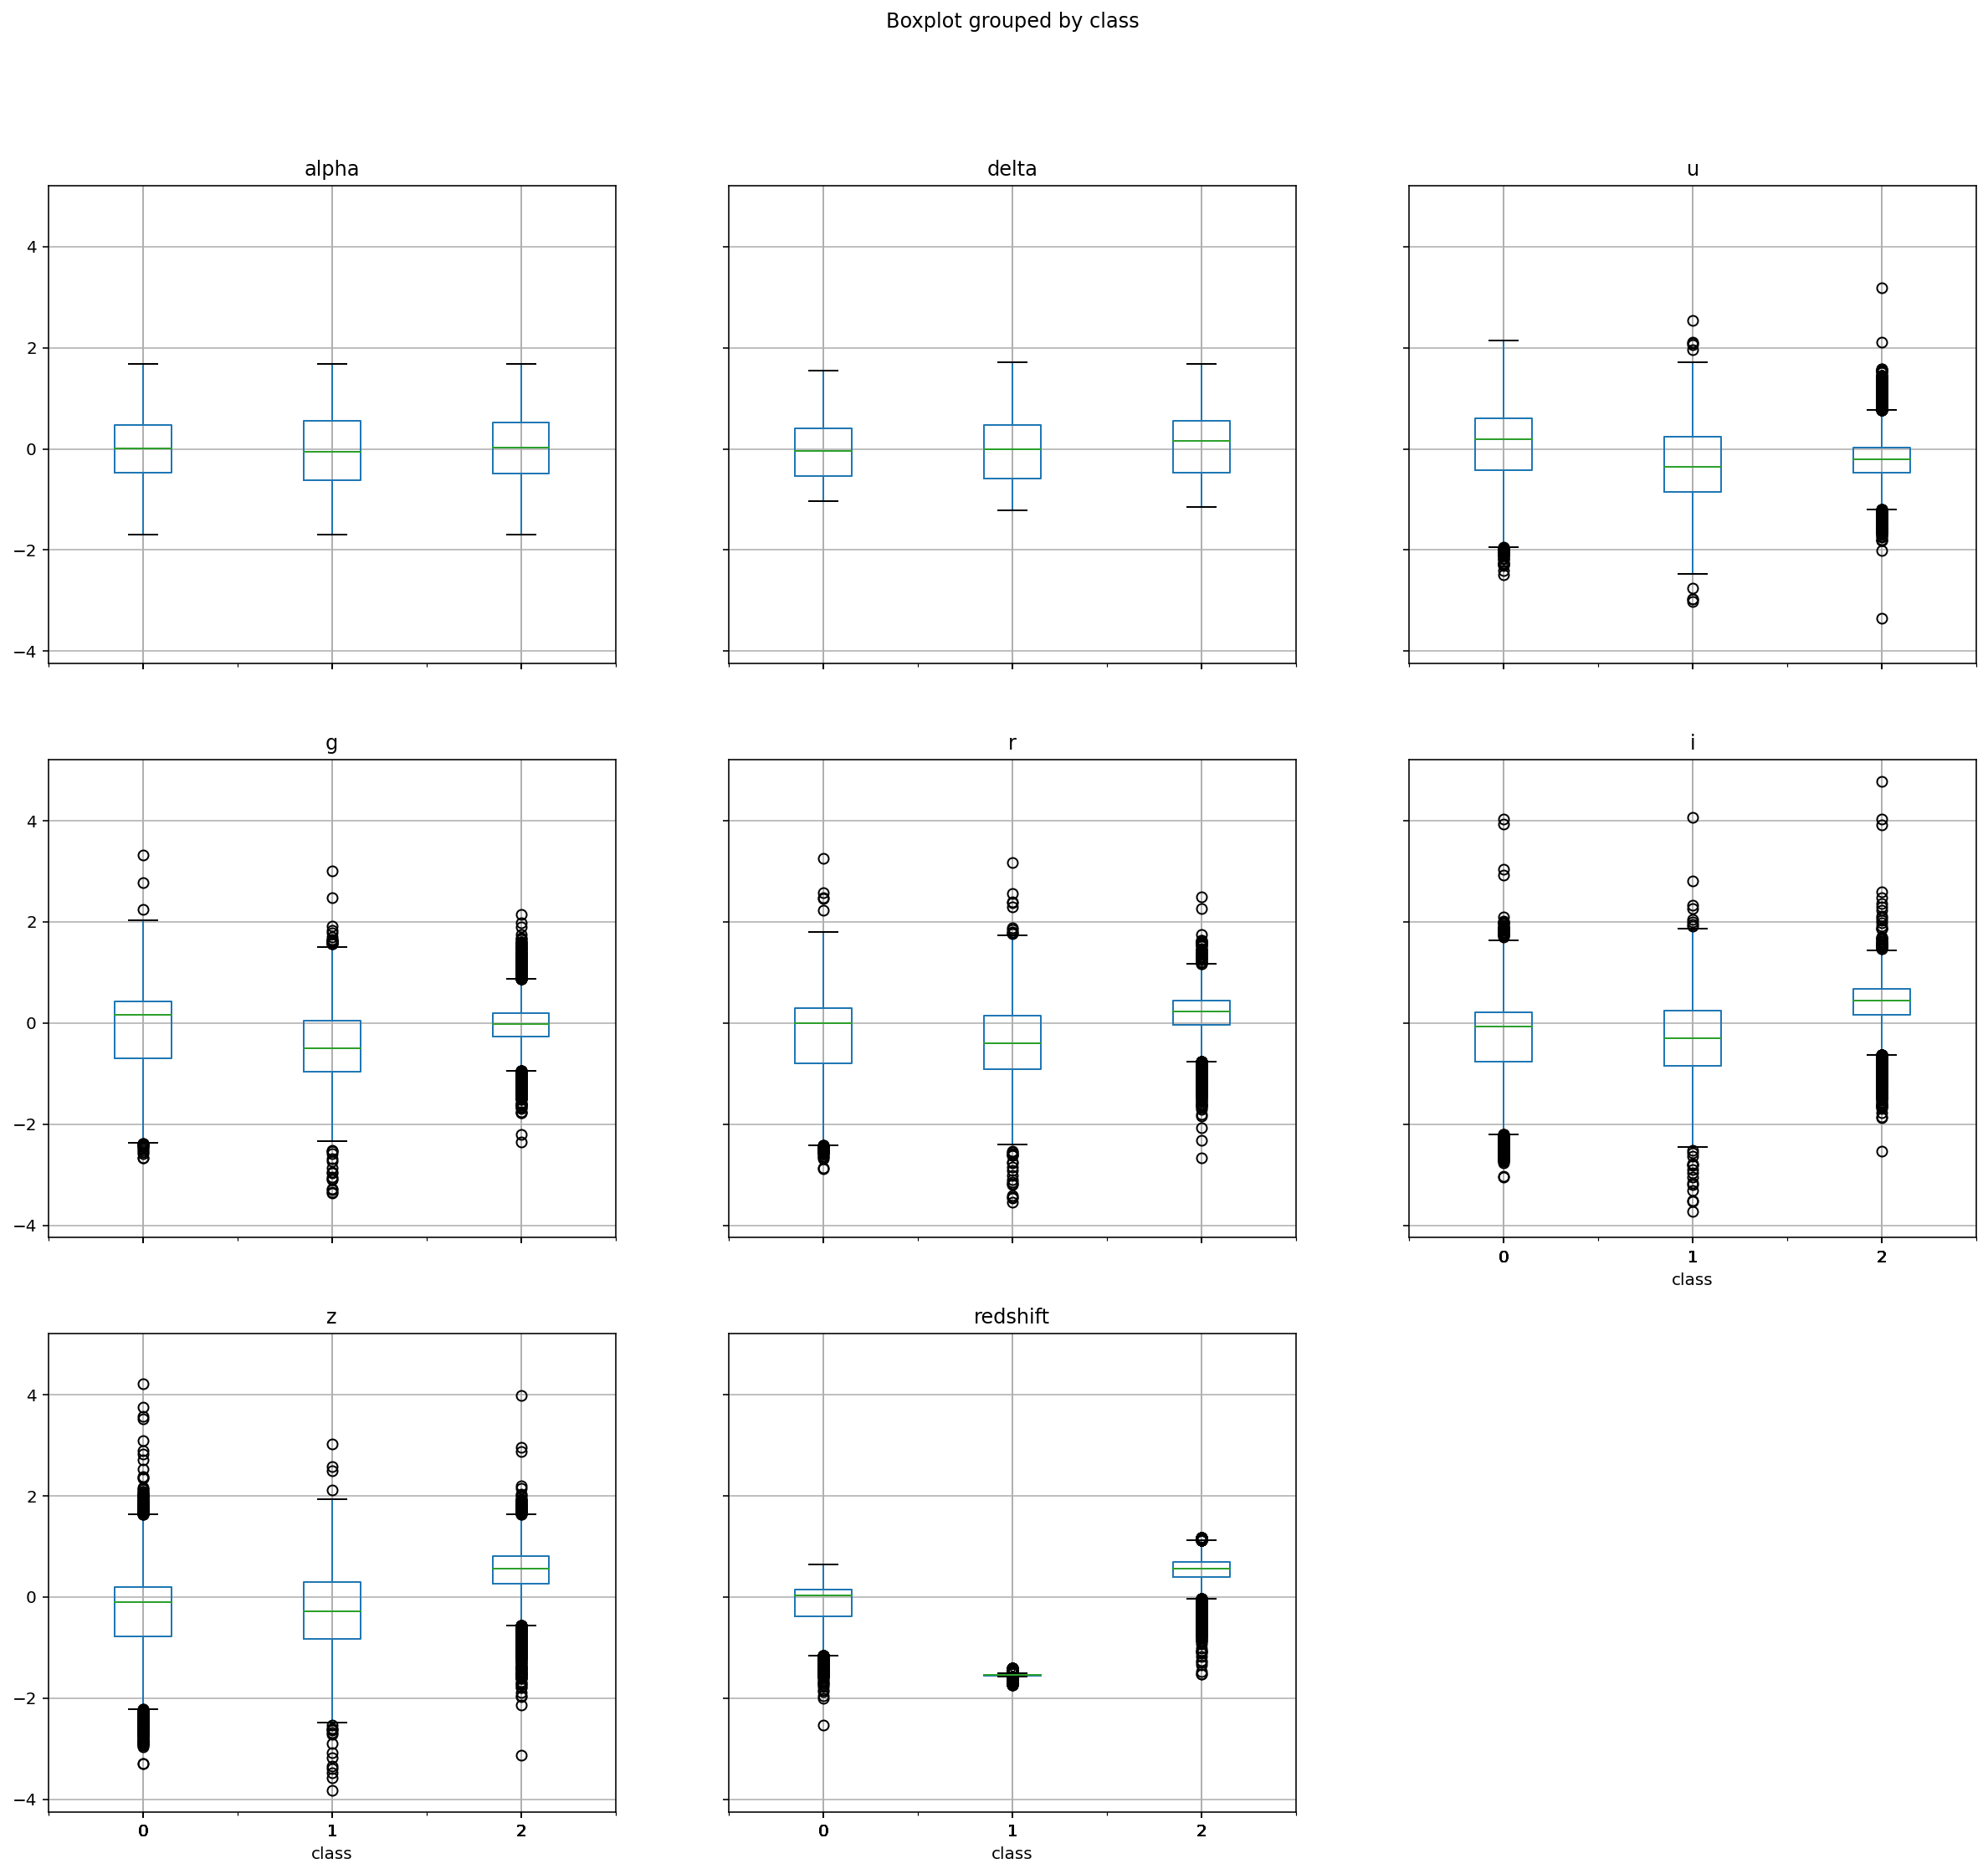

In [30]:
stars_df.boxplot(columns_data, by="class", figsize=(20,18))

# Model Training

The following are the models that will be utizlied for training, hyperparameter tuning and testing of model

1. Logistic Regression
2. Decision Trees
3. K Nearest Neighbors \(or\)
4. Neural Network



### Logistic Regression



In [31]:
X_train_logis = X_train.copy()
y_train_logis = y_train.copy()

In [32]:
from sklearn.linear_model import SGDClassifier

In [33]:
logistic_model = SGDClassifier(loss='log_loss', eta0=0.001, max_iter=200, learning_rate='constant', random_state=1, verbose=0)

In [34]:
max_epochs = 50

In [35]:
from data_loader import DataLoader

In [36]:
data_loader = DataLoader(X_train_logis, y_train_logis, batch_size=1000)

In [37]:
from sklearn.metrics import log_loss

e = 0
is_converged = False
previous_loss = 0
labels = np.unique(y_train_logis)

# For each epoch
while e < max_epochs and is_converged is not True:
    
    loss = 0
    
    X_batch, y_batch = data_loader.get_batch()
    
    for X, y in zip(X_batch, y_batch):
        
        logistic_model.partial_fit(X, y, classes=labels)
        
        y_pred_logis = logistic_model.predict_proba(X_train_logis)
        loss += log_loss(y_train_logis, y_pred_logis)
        
    print('Epoch:', e + 1, '\tLoss:', (loss / len(X_batch)))
    
    if abs(previous_loss - loss) < 0.05:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 0.4332470806462682


Epoch: 2 	Loss: 0.29542526578025985


Epoch: 3 	Loss: 0.27286991901574004


Epoch: 4 	Loss: 0.26164935913833115


Epoch: 5 	Loss: 0.25405025855342545


Epoch: 6 	Loss: 0.2487314082039523


Epoch: 7 	Loss: 0.24461820028620887


Epoch: 8 	Loss: 0.2411686292921902


Epoch: 9 	Loss: 0.2385475138977223


Epoch: 10 	Loss: 0.23636911451867623


Epoch: 11 	Loss: 0.23434819582539304


Epoch: 12 	Loss: 0.23262910018430932


Epoch: 13 	Loss: 0.23127206159791694


Epoch: 14 	Loss: 0.2300202825692897


Epoch: 15 	Loss: 0.22871748878341838


Epoch: 16 	Loss: 0.2278189394458068


Epoch: 17 	Loss: 0.22687549800636328


Epoch: 18 	Loss: 0.22598108892435442


Epoch: 19 	Loss: 0.22529078225380744


In [38]:
### ------END OF LOGISTIC REGRESSION------

### Decision Trees

### K Nearest Neighbors

There is no training when utilizing K Nearest Neighbors



### Neural Network 



# Hyperparameter tuning

### Logistic Regression

### Decision Trees



### K Nearest Neighbors



### Neural Network

# Model selection



# Insight and conclusion


# References